In [2]:
! pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-5yciq3i3
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-5yciq3i3
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


In [5]:
! pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import re
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.layers import Conv1D, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Input,BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import classification_report
from keras.utils import plot_model
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
from tensorflow.keras.datasets import cifar10,fashion_mnist
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling, entropy_sampling
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", message="All log messages before absl::InitializeLog() is called are written to STDERR")

In [10]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)

In [11]:
df = df[[5, 0]]
df.columns=['tweet', 'Sentiment']

In [12]:
df.loc[df["Sentiment"] == 4, "Sentiment"] = 1

In [14]:
stop_words = set(stopwords.words('english'))
def clean_text(sentence):
    # Removing URLS
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence)
    
    # Removing html tags
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence)
    
    # Removing the Punctuation
    sentence = re.sub(r"[^\w\s]", " ", sentence)
        
    # Removing words that have numbers 
    sentence = re.sub(r"\w*\d\w*", " ", sentence)
        
    # Removing Digits 
    sentence = re.sub(r"[0-9]+", " ", sentence)
        
    # Cleaning white spaces
    sentence = re.sub(r"\s+", " ", sentence).strip()
        
    sentence = sentence.lower()
    # Check stop words
    tokens = []
    for token in sentence.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [15]:
df.loc[:, 'tweet'] = df['tweet'].apply(clean_text)

In [16]:
X = df['tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
max_len = 40  # Maximum words in each sequence.
batch_size=512

In [20]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}")

After padding: (1280000, 40)
After padding:(320000, 40)


In [21]:
vocabulary_size = len(tokenizer.word_index)+1
embedding_dim = 100

In [47]:
model = models.Sequential([
layers.Embedding(vocabulary_size, embedding_dim, input_length=max_len),
layers.Dropout(0.5),

layers.Conv1D(filters=128,kernel_size=7,activation='relu'),
layers.Conv1D(filters=128,kernel_size=7,activation='relu'),
layers.GlobalMaxPooling1D(),

layers.Flatten(),
layers.Dense(1024,activation="relu"),
layers.Dropout(0.5),

layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics = ['accuracy'])

In [52]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (512, 40, 100)         │    45,858,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (512, 40, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (512, 34, 128)         │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (512, 28, 128)         │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_10         │ (512, 128)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (512, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (512, 1024)            │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (512, 1024)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (512, 1)               │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,586,997 (528.67 MB)

 Trainable params: 46,195,665 (176.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,391,332 (352.44 MB)

In [59]:
n_instances = 3000
n_queries=5

In [54]:
# Define initial training set
n_initial = 2000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_training_initial, y_training_initial = X_train[initial_idx], y_train.iloc[initial_idx]

# Remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [55]:
accuracy_list = []
X_training = np.copy(X_training_initial)
y_training = np.copy(y_training_initial)

# Make a copy of the pool for each strategy
X_pool_strategy = np.copy(X_pool)
y_pool_strategy = np.copy(y_pool)

# Create the model
optimizer = Adam(learning_rate=0.0001)

estimator = KerasClassifier(model)

    # Initialize an active learner
learner = ActiveLearner(
    estimator=estimator,
    query_strategy=uncertainty_sampling,
    X_training=X_training,
    y_training=y_training)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5234 - loss: 0.6930


In [60]:
for i in range(n_queries):
    # Query the learner to obtain the index of the most informative sample
    query_idx, _ = learner.query(X_pool_strategy, n_instances)

    # Teach the learner with the queried sample
    learner.teach(X_pool_strategy[query_idx], y_pool_strategy[query_idx], only_new=True, verbose=1)

    # remove queried instance from pool
    X_pool_strategy = np.delete(X_pool_strategy, query_idx, axis=0)
    y_pool_strategy = np.delete(y_pool_strategy, query_idx, axis=0)

    # Evaluate the model's performance after teaching
    accuracy = learner.score(X_test, y_test)
    print(f"Iteration {i+1}: Accuracy = {accuracy:.2f}")
    accuracy_list.append(accuracy)

39000/39000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8197 - loss: 0.4248
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Iteration 1: Accuracy = 0.50
38907/38907 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7757 - loss: 0.4765
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Iteration 2: Accuracy = 0.63
38813/38813 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5890 - loss: 0.6556
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Iteration 3: Accuracy = 0.65
38719/38719 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6402 - loss: 0.6392
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Iteration 4: Accuracy = 0.70
38625/38625 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5860 - loss: 0.6689
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Iteration 5: Accuracy = 0.73


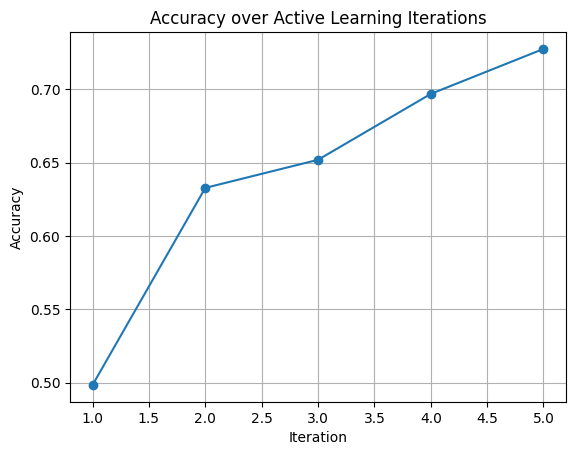

In [65]:
accuracy_list = accuracy_list[10:]
plt.plot(range(1, n_queries + 1), accuracy_list, marker='o')
plt.title('Accuracy over Active Learning Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()